In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_provider import IBMProvider
import pandas as pd
import os
import json

import matplotlib.pyplot as plt
from datetime import datetime

import seaborn as sns
import pickle

plt.rcParams.update({'font.size': 14, 'font.family': 'serif', 'mathtext.fontset': 'dejavuserif'})

In [11]:
service = QiskitRuntimeService(channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='7d8ced7ad49ffe6647211796e4e2ec5c2e03a1eb1a735bc8ecc3fd9f027f7cd5b071557123b89e6ba62b3dce56f415582dcd9d60db45df0d7dd63b5ec943261f')
# IBM Quantum channel; set to default

# Mostro i backend disponibili per l'esecuzione
print(service.backends())

backend_maps = {
    index: backend.name.split('_')[1] for index, backend in enumerate(service.backends())
}
# Inizializzo il backend array 
backend_array=[]
backend_map = backend_map = {index: backend.name.split('_')[1] for index, backend in enumerate(service.backends(operational=True, simulator=False))}

print("Macchine disponibili:")
for index, name in backend_map.items():
    print(f"{index}: {name}")

scelta = input("Scegli un'opzione (1/2): 1 tutte, 2 scegli manualmente ")

# Esegui un'azione in base alla scelta
if scelta == "1":
    print("Hai scelto l'opzione 1!")
    for _, name in backend_maps.items():
            class_name = f"ibm_{name}"  
            try:
                backend_array.append(service.backend(class_name, instance='ibm-q/open/main'))
            except KeyError:
                print(f"Error: Class '{class_name}' not found in qiskit.test.mock.")
    backend_map = {
        index: backend.name.split('_')[1] for index, backend in enumerate(backend_array)
    }
    print(backend_array)
    print(backend_map)
elif scelta == "2":
    print("Hai scelto l'opzione 2!")
    scelte_utente = input("Inserisci gli indici delle macchine separate da una virgola: ")
    indici = [int(i.strip()) for i in scelte_utente.split(',') if i.strip().isdigit()]
    backend_array = []
    new_backend_map = {}
    for index in indici:
        if index in backend_map:
            class_name = f"ibm_{backend_map[index]}"
            try:
                backend = service.backend(class_name, instance='ibm-q/open/main')
                backend_array.append(backend)
                new_backend_map[len(new_backend_map)] = backend.name.split('_')[1]
            except Exception as e:
                print(f"Errore nel trovare la macchina '{class_name}': {e}")
    backend_map = new_backend_map
    print("Macchine selezionate:", [backend.name for backend in backend_array])
    print("Nuovo mapping aggiornato:", backend_map)
else:
    print("Scelta non valida!")

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>]
Macchine disponibili:
0: brisbane
1: sherbrooke
Hai scelto l'opzione 1!
[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>]
{0: 'brisbane', 1: 'sherbrooke'}


In [12]:
def normalized_fractional_hamming_intradistance(dict1, dict2):
    # Verifica se i dizionari hanno le stesse chiavi
    if set(dict1.keys()) != set(dict2.keys()):
        raise ValueError("Response must have the same lenght")
    # Calcola la somma delle differenze assolute tra i valori corrispondenti
    sum_diff = sum(abs((dict1[key] - dict2[key])) for key in dict1.keys())
    fractional_hamming_distance = sum_diff / 2 #len(dict1) perchè la somma ha come range [0,2] quindi /2 per normalizzare a range [0,1]
    return fractional_hamming_distance

In [13]:
n_challenge = int(input("Inserisci il numero di challenge da utilizzare (10/20): "))
n_qubits = int(input("Inserisci il numero di QBITS: "))
shots= int(input("Inserisci il numero shots: "))
n_runs = int(input("Inserisci il numero di runs ")) 

# Unico salvataggio challenge da utilizzare per le tre metriche
# Caricamento da file
file_name = f'./results/configuration_challenges/random_arrays_{n_challenge}.pkl'
with open(file_name, 'rb') as f:
    a_challenge, b_challenge, c_challenge, d_challenge, e_challenge, f_challenge = pickle.load(f)

print(f"Arrays loaded from '{file_name}'")

scelta = input("Scegli un'opzione (1/2/3/4/5/6/7/8): 1 Earth, 2 Mars, 3 Saturn, 4 Jupiter, 5 Venus, 6 Mercury, 7 Uranus, 8 Uranus-Titania")
if scelta == "1":
   print("Hai scelto l'opzione 1 Earth!")
   circuit_type = 'earth'
elif scelta == "2":
   print("Hai scelto l'opzione Mars!")
   circuit_type = 'mars'
elif scelta == "3":
   print("Hai scelto l'opzione Saturn") 
   circuit_type = 'saturn'
elif scelta == "4":
   print("Hai scelto l'opzione Jupiter") 
   circuit_type = 'jupiter' 
elif scelta == "5":
   print("Hai scelto l'opzione Venus") 
   circuit_type = 'venus'
elif scelta == "6":
   print("Hai scelto l'opzione Mercury") 
   circuit_type = 'mercury'
elif scelta == "7":
   print("Hai scelto l'opzione Uranus") 
   circuit_type = 'uranus'
elif scelta == "8":
   print("Hai scelto l'opzione Uranus-Titania") 
   circuit_type = 'uranusTitania'

Arrays loaded from './results/configuration_challenges/random_arrays_20.pkl'
Hai scelto l'opzione Venus


In [14]:
def instability(i):
    inst_table = pd.DataFrame(columns=["n-th challenge", "i-th execution", "j-th execution", "dist"])
    
    file_path = f'./results/backend/real/{circuit_type}/backend_{backend_map[i]}_nq{n_qubits}_nc{n_challenge}_s{shots}_nr{n_runs}.json'
    with open(file_path, 'r') as json_file:
      response=json.load(json_file)

    for n in range(n_challenge):
        #estrae i circuiti solo per quella challenge
        same_response = [response[n*n_runs + k] for k in range(n_runs)]

        for i in range(len(same_response)):
            for j in range(i + 1, len(same_response)):
                distance = normalized_fractional_hamming_intradistance(same_response[i], same_response[j])
                inst_table.loc[len(inst_table)] = [n, i, j, distance]
    
    inst_table[['n-th challenge', 'i-th execution', 'j-th execution']] = inst_table[['n-th challenge', 'i-th execution', 'j-th execution']].astype(int)
    return inst_table

def randomness(i): 
  rand_table =pd.DataFrame(columns=["n-th challenge", "m-th challenge", "dist"])
  #cosi mi ricrea il backend e perdo il salvataggio precendente
 
  file_path = f'./results/backend/real/{circuit_type}/backend_{backend_map[i]}_nq{n_qubits}_nc{n_challenge}_s{shots}_nr{n_runs}.json'
  with open(file_path, 'r') as json_file:
    response=json.load(json_file)

  all_same_runs= []

  for i in range(n_challenge):
    same_runs = response[0+(i*n_runs)]  #devo skippare nruns alla volta e le isolo prima (cioe le tiro fuori)
    all_same_runs.append(same_runs)
  
  for n in range(len(all_same_runs)):
    for m in range(n + 1, len(all_same_runs)): # per evitare di calcolare la distanza tra le stesse coppie ma ordine invertito
      distance = normalized_fractional_hamming_intradistance(all_same_runs[n], all_same_runs[m])
      rand_table.loc[len(rand_table)] = [n, m, distance]
    
  rand_table['n-th challenge']=rand_table['n-th challenge'].astype(int)
  rand_table['m-th challenge']=rand_table['m-th challenge'].astype(int)
  return rand_table

def uniqueness():
  unique_table = pd.DataFrame(columns=["i-th device","j-th device","n-th challenge", "dist"])
  responses=[]
  for i in range(len(backend_array)):
    file_path = f'./results/backend/real/{circuit_type}/backend_{backend_map[i]}_nq{n_qubits}_nc{n_challenge}_s{shots}_nr{n_runs}.json'
    with open(file_path, 'r') as json_file:
      r=json.load(json_file)
    responses.append(r)  
  
  # Mantengo la struttura: macchina -> challenge -> run
  all_same_runs = []
  for i in range(len(backend_array)):  # Lunghezza dei backend
      machine_challenges = []  # Lista per le challenge di questa macchina
      for j in range(n_challenge):
          # Estrai i run per questa challenge
          same_runs = responses[i][j*n_runs]  # Prendo tutti i challenge per della stessa runs
          machine_challenges.append(same_runs)  # Aggiungo le challenge della run alla lista della macchina
      all_same_runs.append(machine_challenges)  # Aggiungo la struttura della macchina
  
  for i in range(len(backend_array)): #lunghezza backend
    for j in range(i + 1, len(backend_array)):
      for n in range(n_challenge):
        #print(f"macchina {i} e macchina {j} su challenge {n}")
        distance = normalized_fractional_hamming_intradistance(all_same_runs[i][n], all_same_runs[j][n])
        unique_table.loc[len(unique_table)] = [i,j,n, distance]
  unique_table['i-th device']=unique_table['i-th device'].astype(int)
  unique_table['j-th device']=unique_table['j-th device'].astype(int)
  unique_table['n-th challenge']=unique_table['n-th challenge'].astype(int)
  return unique_table

In [15]:
if len(backend_array) < 1:
    raise ValueError("Errore: Nessuna macchina selezionata, impossibile eseguire i test.")

current_time = datetime.now().strftime("%Y-%m-%d__%H-%M")
folder_name = f'{circuit_type}_nq{n_qubits}_nc{n_challenge}_s{shots}_{n_runs}_{current_time}'

# Percorso delle cartelle da creare
folder_paths = [
    f'./results/instability/real/{folder_name}',
    f'./results/randomness/real/{folder_name}',
]

# Se la dimensione di backend_array è maggiore di 1, aggiungi la cartella uniqueness
if len(backend_array) > 1:
    folder_paths.append(f'./results/uniqueness/real/{folder_name}')

# Creazione delle cartelle se non esistono già
for folder_path in folder_paths:
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Cartella '{folder_path}' creata con successo.")
    else:
        print(f"La cartella '{folder_path}' esiste già.")

inst_table=[]

rand_table=[]

for i, backend_name in backend_map.items():
    if(n_runs < 2):
       print("Instability non calcolabile con una sola runs!")
    else:
      inst_table.append(instability(i))
      file_path = f'./results/instability/real/{folder_name}/inst_table_{backend_name}_nq{n_qubits}_nc{n_challenge}_s{shots}_nr{n_runs}.csv'
      inst_table[i].to_csv(file_path, index=False)
      print("Dati salvati correttamente in:", file_path)

    rand_table.append(randomness(i))
    file_path = f'./results/randomness/real/{folder_name}/rand_table_{backend_name}_nq{n_qubits}_nc{n_challenge}_s{shots}_nr{n_runs}.csv'
    rand_table[i].to_csv(file_path, index=False)
    print("Dati salvati correttamente in:", file_path)


if(len(backend_array) < 2):
  print("Uniqueness non calcolabile con una sola macchina!")
else:
  unique_table=uniqueness()
  file_path = f'./results/uniqueness/real/{folder_name}/unique_table_nq{n_qubits}_nc{n_challenge}_s{shots}_nr{n_runs}.csv'
  unique_table.to_csv(file_path, index=False)
  print("Dati salvati correttamente in:", file_path)
  unique_table
    
inst_table[0]
rand_table[0]

Cartella './results/instability/real/venus_nq8_nc20_s20000_5_2025-05-17__12-43' creata con successo.
Cartella './results/randomness/real/venus_nq8_nc20_s20000_5_2025-05-17__12-43' creata con successo.
Cartella './results/uniqueness/real/venus_nq8_nc20_s20000_5_2025-05-17__12-43' creata con successo.
Dati salvati correttamente in: ./results/instability/real/venus_nq8_nc20_s20000_5_2025-05-17__12-43/inst_table_brisbane_nq8_nc20_s20000_nr5.csv
Dati salvati correttamente in: ./results/randomness/real/venus_nq8_nc20_s20000_5_2025-05-17__12-43/rand_table_brisbane_nq8_nc20_s20000_nr5.csv
Dati salvati correttamente in: ./results/instability/real/venus_nq8_nc20_s20000_5_2025-05-17__12-43/inst_table_sherbrooke_nq8_nc20_s20000_nr5.csv
Dati salvati correttamente in: ./results/randomness/real/venus_nq8_nc20_s20000_5_2025-05-17__12-43/rand_table_sherbrooke_nq8_nc20_s20000_nr5.csv
Dati salvati correttamente in: ./results/uniqueness/real/venus_nq8_nc20_s20000_5_2025-05-17__12-43/unique_table_nq8_nc20_

,n-th challenge,m-th challenge,dist
0,0,1,0.59840
1,0,2,0.68415
2,0,3,0.56500
3,0,4,0.64245
4,0,5,0.64705
...,...,...,...
185,16,18,0.60220
186,16,19,0.65880
187,17,18,0.62325
188,17,19,0.67645


# Risultati instability

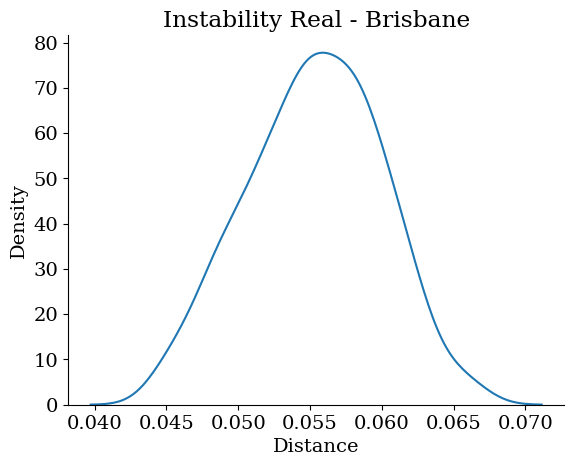

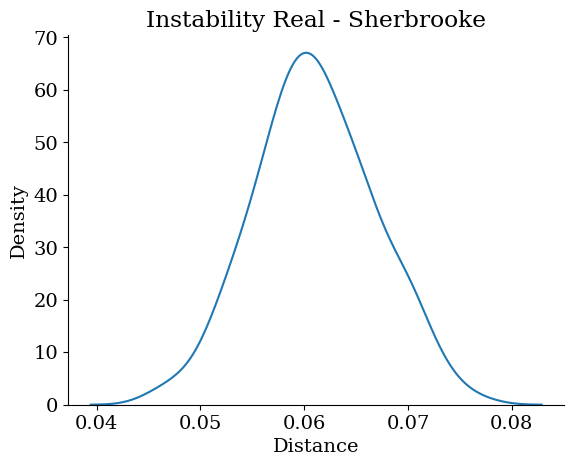

In [16]:
if(n_runs < 2):
    print("Instability non calcolabile con una sola runs!")
else:
    for i, (backend_name, tab) in enumerate(zip(backend_map.values(), inst_table)):
        sns.kdeplot(tab['dist'])
        # Setto il titolo del grafico alla relativa macchina
        plt.title(f'Instability Real - {backend_name.capitalize()}')
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.xlabel('Distance')
        # Salvo con il nome relativo della macchina
        plt.savefig(f'./results/instability/real/{folder_name}/instability_{backend_name}_nq{n_qubits}_nc{n_challenge}_s{shots}_nr{n_runs}.png')
        # Visualizzo il grafico
        plt.show()

## Risultati Randomness

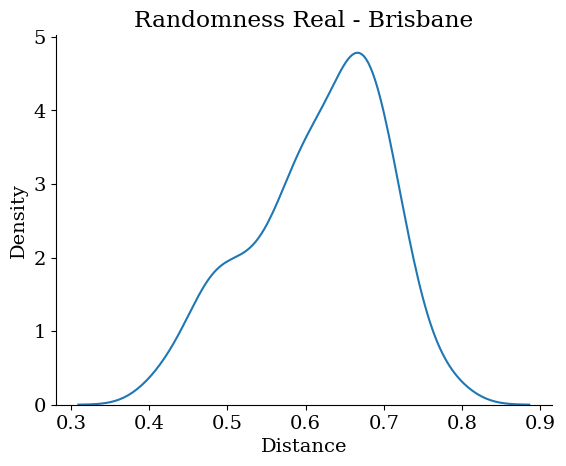

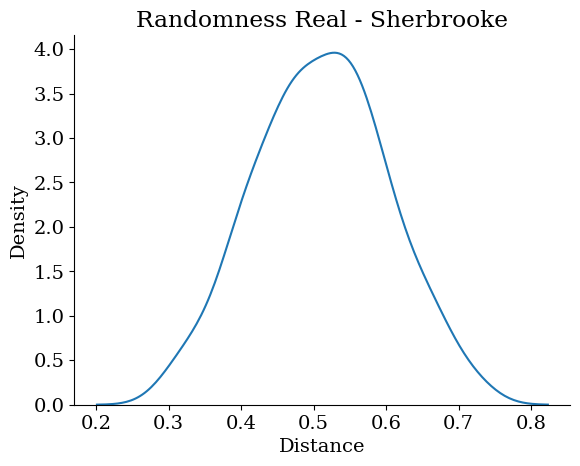

In [17]:
for i, (backend_name, tab) in enumerate(zip(backend_map.values(), rand_table)):
    sns.kdeplot(tab['dist'])
    plt.title(f'Randomness Real - {backend_name.capitalize()}')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('Distance')
    
    plt.savefig(f'./results/randomness/real/{folder_name}/randomness_real_{backend_name}_nq{n_qubits}_nc{n_challenge}_s{shots}_nr{n_runs}.png')
    
    plt.show()

## Risultati Uniqueness

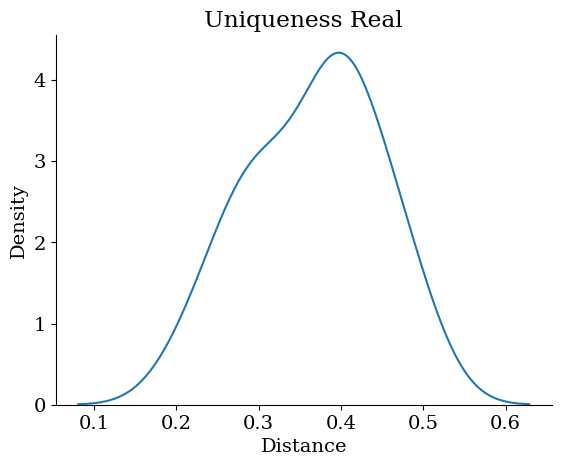

In [18]:
if(len(backend_array) < 2):
    print("Uniqueness non calcolabile con meno di 2 macchine")
else:
    sns.kdeplot(unique_table['dist'])
    plt.title('Uniqueness Real')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('Distance')

    plt.savefig(f'./results/uniqueness/real/{folder_name}/uniqueness_nq{n_qubits}_nc{n_challenge}_s{shots}_nr{n_runs}.png')

    plt.show()